# Real Estate Price Prediction

## Подключение библиотек и скриптов

In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd

import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# 3. Используемая модель (метрика была лучше всех)
from catboost import CatBoostRegressor

# 4. Метрики качества
from sklearn.metrics import r2_score as r2

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams.update({'font.size': 14})

### Функция вывода метрики R2 и визуализация расчетной и фактической стоимости

In [2]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Функция уменьшения объема памяти, занимаемого датасетом

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('object')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Пути к файлам

In [4]:
TRAIN_DATASET_PATH = 'data/train.csv'
TEST_DATASET_PATH = 'data/test.csv'
SUBMISSION_DATASET_PATH = 'data/sample_submission.csv'

## Загрузка данных

#### Описание датасета:

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.69 MB
Decreased by 55.0%


In [6]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750


In [7]:
train_df.dtypes

Id                 int16
DistrictId         int16
Rooms            float32
Square           float32
LifeSquare       float32
KitchenSquare    float32
Floor               int8
HouseFloor       float32
HouseYear          int32
Ecology_1        float32
Ecology_2         object
Ecology_3         object
Social_1            int8
Social_2           int16
Social_3           int16
Healthcare_1     float32
Helthcare_2         int8
Shops_1             int8
Shops_2           object
Price            float32
dtype: object

In [8]:
for i in train_df:
    print(i, train_df[i].drop_duplicates().shape[0])

Id 10000
DistrictId 205
Rooms 9
Square 9995
LifeSquare 7887
KitchenSquare 58
Floor 33
HouseFloor 44
HouseYear 97
Ecology_1 129
Ecology_2 2
Ecology_3 2
Social_1 51
Social_2 142
Social_3 30
Healthcare_1 80
Helthcare_2 7
Shops_1 16
Shops_2 2
Price 9996


#### У признаки, вариативность которых < 20, был изменен тип данных, так как это, скорее всего, категориальные признаки.

In [9]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['Social_3'] = train_df['Social_3'].astype(str)
train_df['Helthcare_2'] = train_df['Helthcare_2'].astype(str)
train_df['Shops_1'] = train_df['Shops_1'].astype(str)

## EDA

### Распределение целевой переменной

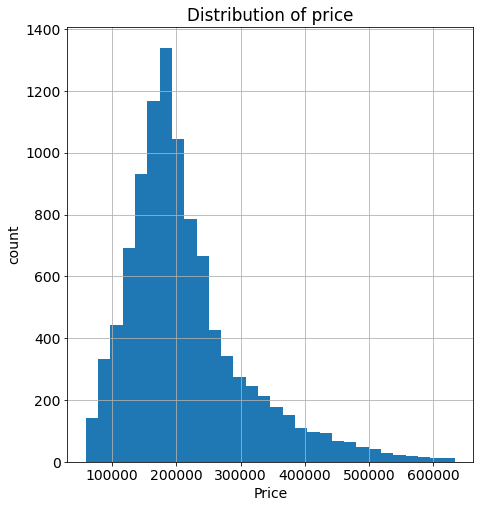

In [10]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist(density=False, bins=30)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Distribution of price')
plt.show()

In [11]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Healthcare_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000
mean,50.400800,1.890500,56.315777,37.199646,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,1142.904419,214138.859375
std,43.587592,0.839512,21.058731,86.241211,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,1021.517273,92872.289062
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,59174.777344
25%,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,350.000000,153872.628906
50%,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,900.000000,192269.648438
75%,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,1548.000000,249135.460938
max,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,4849.000000,633233.437500


## Обработка выбросов

### Rooms

In [12]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [13]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1

In [14]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

### Square

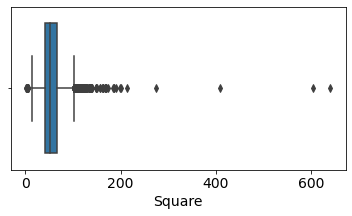

In [15]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Square'], whis=1.5)

plt.xlabel('Square')
plt.show()

<AxesSubplot:>

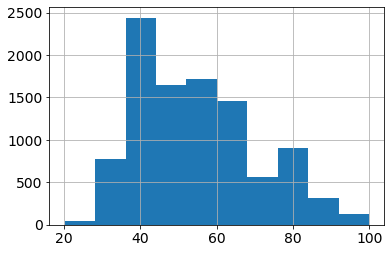

In [16]:
train_df.loc[(train_df['Square'] > 100) | (train_df['Square'] < 20), 'Square'] = train_df['Square'].median()
train_df['Square'].hist()

### LifeSquare

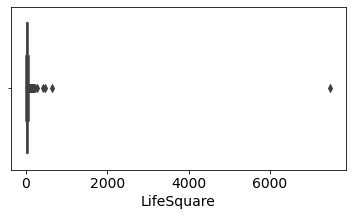

In [17]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['LifeSquare'], whis=1.5)

plt.xlabel('LifeSquare')
plt.show()

<AxesSubplot:>

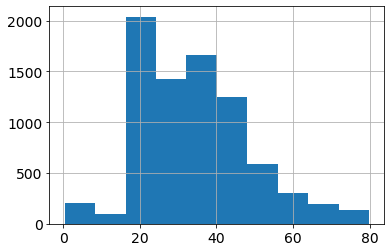

In [18]:
train_df.loc[(train_df['LifeSquare'] > 80), 'LifeSquare'] = train_df['LifeSquare'].median()
train_df['LifeSquare'].hist()

### KitchenSquare

In [19]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [20]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

### HouseFloor

In [21]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [22]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [23]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [24]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

### HouseYear

In [25]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

In [26]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

## Обработка пропусков

In [27]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

### LifeSquare

In [28]:
train_df['LifeSquare_nan'] = 0

train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1

train_df['LifeSquare_nan'].value_counts()

0    7887
1    2113
Name: LifeSquare_nan, dtype: int64

In [29]:
median_ls = train_df['LifeSquare'].median()
train_df['LifeSquare'] = train_df['LifeSquare'].fillna(median_ls)
train_df['LifeSquare'].isna().sum()

0

### Healthcare_1

In [30]:
train_df['Healthcare_1_nan'] = 0

train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1

train_df['Healthcare_1_nan'].value_counts()

0    5202
1    4798
Name: Healthcare_1_nan, dtype: int64

In [31]:
median_ls = train_df['Healthcare_1'].median()
train_df['Healthcare_1'] = train_df['Healthcare_1'].fillna(median_ls)
train_df['Healthcare_1'].isna().sum()

0

### Функция подготовки исходных данных

In [32]:
class DataPreprocessing:

    def __init__(self):
        self.medians = None
        
# Статистика
    def fit(self, df):     
        # Расчет медиан
        self.medians = df.median()
        self.kitchen_square_quantile = df['KitchenSquare'].quantile(.975)
        self.HouseFloor_min = 1
        self.HouseFloor_max = 50
    
# Трансформация данных
    def transform(self, df):
        df = reduce_mem_usage(df)
        
        df['Id'] = df['Id'].astype(str)
        df['Social_3'] = df['Social_3'].astype(str)
        df['Helthcare_2'] = df['Helthcare_2'].astype(str)
        df['Shops_1'] = df['Shops_1'].astype(str)
        
        # Выбросы
        # Rooms
        df['Rooms_outlier'] = 0
        df.loc[(df['Rooms'] == 0) | (df['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        df.loc[df['Rooms'] == 0, 'Rooms'] = 1
        df.loc[df['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # Square
        df.loc[(df['Square'] > 100) | (df['Square'] < 20), 'Square'] = self.medians['Square']

        # LifeSquare
        df.loc[(df['LifeSquare'] > 80), 'LifeSquare'] = self.medians['LifeSquare']
        
        # KitchenSquare
        condition = (df['KitchenSquare'].isna()) \
                    | (df['KitchenSquare'] > self.kitchen_square_quantile)
        
        df.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        df.loc[df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor
        df['HouseFloor_outlier'] = 0
        df.loc[df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor_outlier'] = 1

        df.loc[(df['HouseFloor'] < self.HouseFloor_min), 'HouseFloor'] = self.HouseFloor_min
        df.loc[(df['HouseFloor'] > self.HouseFloor_max), 'HouseFloor'] = self.HouseFloor_max
        
        floor_outliers = df.loc[df['Floor'] > df['HouseFloor']].index
        df.loc[floor_outliers, 'Floor'] = df.loc[floor_outliers, 'HouseFloor']\
        .apply(lambda x: self.HouseFloor_min if (self.HouseFloor_min == x) else np.random.randint(self.HouseFloor_min, x))
                
        # HouseYear
        df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020
        
        # Пропуски
        # LifeSquare
        df['LifeSquare_nan'] = 0
        df.loc[df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
        
        df['LifeSquare'].fillna(self.medians['LifeSquare'], inplace=True)
        
        # Healthcare_1
        df['Healthcare_1_nan'] = 0
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
        df['Healthcare_1'].fillna(self.medians['Healthcare_1'], inplace=True)
        
        return df

## Построение новых признаков

In [33]:
train_df.drop(columns=['Id'], inplace=True)

### Доля жилой площади относительно общей площади

In [34]:
train_df['LifeSquare_share'] = train_df['LifeSquare'] / train_df['Square'] * 100
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_nan,LifeSquare_share
0,27,3.0,52.513309,32.781261,10.0,4,10.0,2014,0.075424,B,...,900.0,0,0,B,305018.875000,0,0,1,1,62.424671
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,...,1183.0,1,0,B,177734.546875,0,0,0,0,58.166592
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,...,240.0,3,1,B,282078.718750,0,0,0,0,60.850937
3,1,1.0,40.409908,32.781261,3.0,10,22.0,1977,0.007122,B,...,900.0,0,1,B,168106.000000,0,0,1,1,81.121841
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,...,900.0,0,6,B,343995.093750,0,0,0,1,59.986740


### Ecology_2, Ecology_3, Shops_2 (Бинарные переменные)

In [35]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

### DistrictSize, IsDistrictLarge

In [36]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [37]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

### Среднее значение признака Healthcare_1 по району

In [38]:
Healthcare_1_by_DistrictId = train_df.groupby('DistrictId', as_index=False).agg({'Healthcare_1': 'mean'})\
            .rename(columns={'Healthcare_1': 'AverageHealthcare_1'})

In [39]:
train_df = train_df.merge(Healthcare_1_by_DistrictId, on="DistrictId", how='left')
train_df['AverageHealthcare_1'].fillna(train_df['AverageHealthcare_1'].median(), inplace=True)

In [40]:
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,Healthcare_1_nan,LifeSquare_share,DistrictSize,IsDistrictLarge,AverageHealthcare_1
0,27,3.0,52.513309,32.781261,10.0,4,10.0,2014,0.075424,1,...,1,305018.875000,0,0,1,1,62.424671,851,1,900.000000
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,...,1,177734.546875,0,0,0,0,58.166592,78,0,1194.769287
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,...,1,282078.718750,0,0,0,0,60.850937,652,1,841.319031
3,1,1.0,40.409908,32.781261,3.0,10,22.0,1977,0.007122,1,...,1,168106.000000,0,0,1,1,81.121841,652,1,841.319031
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,...,1,343995.093750,0,0,0,1,59.986740,89,0,900.000000


### Функция генерации новых данных

In [41]:
class FeatureGenetator():
    
    def __init__(self):
       
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.district_size = None
        self.Healthcare_1_by_DistrictId = None
        
    def fit(self, df, y=None):
        
        df = df.copy()
        self.medians = df.median()
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = df['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        
        # подсчет среднего значения признака Healthcare_1 по району
        self.Healthcare_1_by_DistrictId = train_df.groupby('DistrictId', as_index=False)\
            .agg({'Healthcare_1': 'mean'})\
            .rename(columns={'Healthcare_1': 'AverageHealthcare_1'})
        self.medians['AverageHealthcare_1'] = self.Healthcare_1_by_DistrictId['AverageHealthcare_1'].median()
                
    def transform(self, df):
        df = reduce_mem_usage(df)
        
        # Доля жилой площади относительно общей площади
        df['LifeSquare_share'] = df['LifeSquare'] / df['Square'] * 100
        
        # Бинарные переменные
        df['Ecology_2'] = df['Ecology_2'].map(self.binary_to_numbers)  
        df['Ecology_3'] = df['Ecology_3'].map(self.binary_to_numbers)
        df['Shops_2'] = df['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        df = df.merge(self.district_size, on='DistrictId', how='left')
        
        df['new_district'] = 0
        df.loc[df['DistrictSize'].isna(), 'new_district'] = 1
        
        df['DistrictSize'].fillna(5, inplace=True)
        
        df['IsDistrictLarge'] = (df['DistrictSize'] > 100).astype(int)
        
        # Среднее значение Healthcare_1 по району
        df = df.merge(self.Healthcare_1_by_DistrictId, on='DistrictId', how='left')
        df['AverageHealthcare_1'].fillna(self.medians['AverageHealthcare_1'], inplace=True)
        
       
        return df

## Отбор новых признаков

In [42]:
train_df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_outlier',
 'HouseFloor_outlier',
 'LifeSquare_nan',
 'Healthcare_1_nan',
 'LifeSquare_share',
 'DistrictSize',
 'IsDistrictLarge',
 'AverageHealthcare_1']

In [43]:
model_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2', 'LifeSquare_share', 'Rooms_outlier', 'DistrictSize', 
                     'new_district', 'IsDistrictLarge', 'LifeSquare_nan', 'Healthcare_1_nan']


target_name = 'Price'

## Разбиение на train и test

In [44]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [45]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [46]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

Memory usage of dataframe is 1.02 MB
Memory usage after optimization is: 0.49 MB
Decreased by 52.5%
Memory usage of dataframe is 0.50 MB
Memory usage after optimization is: 0.23 MB
Decreased by 53.8%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.31 MB
Decreased by 56.6%


((6700, 23), (3300, 23), (5000, 23))

In [47]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

Memory usage of dataframe is 1.15 MB
Memory usage after optimization is: 0.92 MB
Decreased by 20.5%
Memory usage of dataframe is 0.56 MB
Memory usage after optimization is: 0.45 MB
Decreased by 19.5%
Memory usage of dataframe is 0.62 MB
Memory usage after optimization is: 0.46 MB
Decreased by 26.7%


((6700, 28), (3300, 28), (5000, 28))

In [48]:
X_train = X_train[model_features]
X_valid = X_valid[model_features]
test_df = test_df[model_features]

## Построение модели

### Обучение

In [49]:
cat = CatBoostRegressor(iterations=1000, max_depth=8, eval_metric='R2', random_state=42)
cat.fit(X_train,y_train, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Оценка модели

Train R2:	0.945
Test R2:	0.761


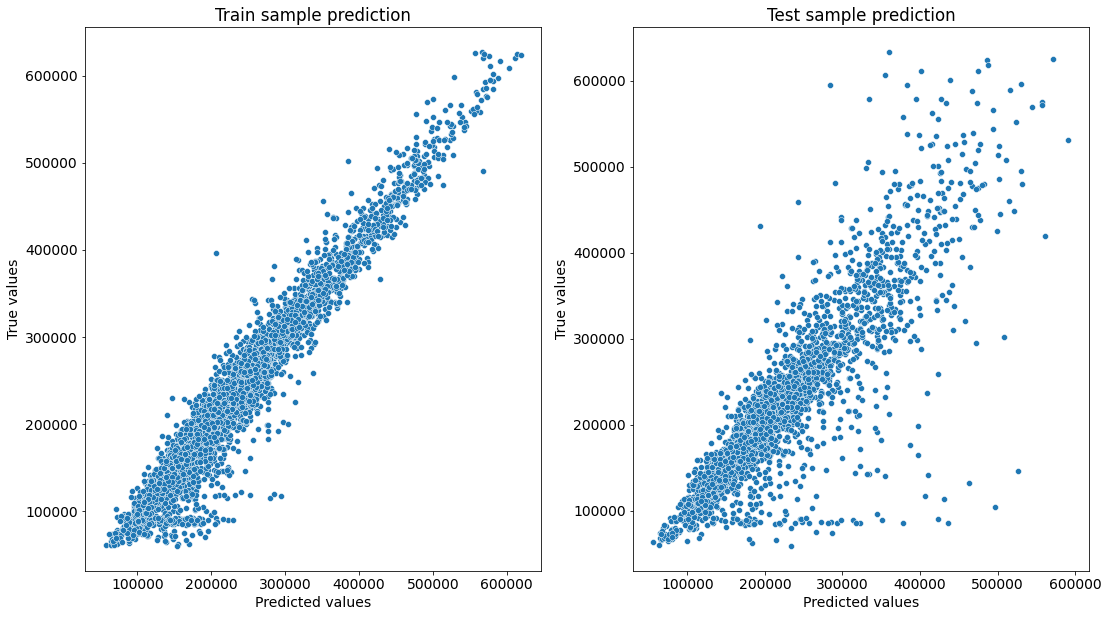

In [50]:
y_train_preds = cat.predict(X_train)
y_valid_preds = cat.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

### Кросс-валидация

In [51]:
cv_score = cross_val_score(cat, X_train, y_train, fit_params= {'verbose': 0}, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.75634537, 0.70096959, 0.71781565, 0.73825389, 0.75643421])

In [52]:
cv_score.mean()

0.7339637409693811

In [53]:
cv_score.std()

0.02178825240565646

## Прогнозирование на тестовом датасете

In [54]:
test_df.shape

(5000, 23)

In [55]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Helthcare_2,Shops_1,Shops_2,LifeSquare_share,Rooms_outlier,DistrictSize,new_district,IsDistrictLarge,LifeSquare_nan,Healthcare_1_nan
0,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,1,1,...,1,1,1,51.819302,0,76.0,0,0,0,0
1,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,1,1,...,0,0,0,100.174675,0,164.0,0,1,0,1
2,2.0,59.463676,32.679352,9.0,19,19.0,1977,0.211401,1,1,...,0,1,1,54.956829,0,580.0,0,1,1,1
3,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,1,1,...,0,0,1,68.270966,0,372.0,0,1,0,1
4,1.0,53.837055,32.679352,3.0,8,17.0,1977,0.309479,1,1,...,0,6,1,60.700481,0,65.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,1,5.0,1962,0.069660,1,1,...,1,2,1,70.267914,0,56.0,0,0,0,1
4996,3.0,93.698120,32.679352,10.0,21,27.0,2018,0.060753,1,1,...,0,7,1,34.877277,0,26.0,0,0,0,0
4997,1.0,33.656723,19.003260,5.0,2,5.0,1966,0.038693,1,1,...,2,5,1,56.462002,0,54.0,0,0,0,0
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,0,11,1,54.293186,0,40.0,0,0,0,1


In [56]:
submit = pd.read_csv(SUBMISSION_DATASET_PATH)
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [57]:
predictions = cat.predict(test_df)
predictions

array([166334.80031358, 118756.52161016, 144690.17597936, ...,
       149303.4746723 , 197143.96648473, 232556.26047457])

In [58]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,166334.800314
1,5925,118756.521610
2,960,144690.175979
3,3848,132214.503893
4,746,210365.765449


In [59]:
submit.to_csv('data/submit.csv', encoding='utf-8', index=False)